In [1]:
import os
import pandas as pd
import time
from openai import OpenAI
from groq import Groq
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from dotenv import load_dotenv, dotenv_values

In [2]:
# 1. Setup
# API Clients
#load_dotenv()
config = dotenv_values(".env")
groq_client = Groq(api_key=config["GROQ_API_KEY"])
openai_client = OpenAI(api_key=config["OPENAI_API_KEY"])


# groq_client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
# openai_client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Model configs
GROQ_MODEL = "llama3-8b-8192"  
OPENAI_MODEL = "gpt-3.5-turbo-1106"  # "gpt-4-1106-preview"

TEMPERATURE = 0.2
MAX_TOKENS = 20
#BATCH_SIZE = 5

# File paths
TEST_FILE = "test.csv"
OUTPUT_FILE = "test_predictions.csv"

# Save frequency
FREQUENCY = 250

In [3]:
# 2. Load Data
full_test_df = pd.read_csv(TEST_FILE)
sample_test_df = full_test_df.sample(n=20, random_state=42).reset_index(drop=True)

In [4]:
# 3. Prompt Styles
def build_prompt(question, correct_answer, response, style="fewshot"):
    if style == "fewshot":
        prompt = f"""
                    You are grading a short answer exam.
                    
                    Examples:
                    Question: Name one potential disadvantage of experiments
                    CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run
                    Response: they can be unethical
                    Label: 1
                    
                    Question: Name one potential disadvantage of experiments
                    CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run
                    Response: Harmful effects towards those being expeiremneted on
                    Label: 0
                    
                    Question: Name one potential disadvantage of experiments
                    CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run
                    Response: They can be biased or unbiased
                    Label: -1
                    
                    Now grade this:
                    Question: {question}
                    CorrectAnswer: {correct_answer}
                    Response: {response}

                    Your answer (only -1, 0, or 1):
                """
    elif style == "cot":
        prompt = f"""
                    You are a short answer grader. Think step-by-step.
                    
                    1. Analyze if the Response matches the key information in the CorrectAnswer.
                    2. Decide:
                        - If correct, output 1.
                        - If similar but not exact, output 0.
                        - If wrong, output -1.
                    
                    Question: {question}
                    CorrectAnswer: {correct_answer}
                    Response: {response}
                    
                    Your analysis and final Label (only -1, 0, or 1):
                """
    return prompt

In [5]:
# Prompt for Batching, but LLM keeps giving inconsistent answers while occasionally dropping answers for some questions
SHARED_FEWSHOT = (
    "You are grading a short answer exam.\n\n"
    "Examples:\n"
    "Question: Name one potential disadvantage of experiments\n"
    "CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run\n"
    "Response: they can be unethical\n"
    "Label: 1\n\n"
    "Question: Name one potential disadvantage of experiments\n"
    "CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run\n"
    "Response: Harmful effects towards those being expeiremneted on\n"
    "Label: 0\n\n"
    "Question: Name one potential disadvantage of experiments\n"
    "CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run\n"
    "Response: They can be biased or unbiased\n"
    "Label: -1\n\n"
    "Now grade these:\n"
    "Respond with only one line per answer using only -1, 0, or 1.\n"
)

SHARED_COT = (
    "You are a short answer grader. Think step-by-step.\n\n"
    "1. Analyze if the Response matches the key information in the CorrectAnswer.\n"
    "2. Decide:\n"
    "   - If correct, output 1.\n"
    "   - If similar but not exact, output 0.\n"
    "   - If wrong, output -1.\n\n"
    "Now evaluate the following:\n"
    "Respond with only one line per answer using only -1, 0, or 1.\n"
)

In [6]:
# 4. Parse Output for Batched Response
def parse_prediction(pred):
    try:
        pred = str(pred).strip()
        # Match formats like "1", "-1", or "2. 0", "3: 1"
        match = re.match(r"^\s*(\d+[\.:])?\s*(-?1|0)\s*$", pred)
        if match:
            value = int(match.group(2))
            return value
    except:
        pass
    return None

In [7]:
# Likely to miss output for some questions in LLaMA model and occasionally in GPT3.5 as well
'''
def run_batched_inference(df, model_type="groq", style="fewshot"):
    if os.path.exists(OUTPUT_FILE):
        results = pd.read_csv(OUTPUT_FILE)
    else:
        results = df.copy()

    col_name = f"{model_type}_pred_{style}"
    if col_name not in results.columns:
        results[col_name] = None

    for start in range(0, len(results), BATCH_SIZE):
        batch = results.iloc[start:start + BATCH_SIZE]
        indices = batch.index
        batch = batch[~results.loc[indices, col_name].isin([-1, 0, 1])]
        if batch.empty:
            continue

        examples = []
        for i, (_, row) in enumerate(batch.iterrows(), 1):
            example = (
                f"Question: {row['Question']}\n"
                f"CorrectAnswer: {row['CorrectAnswer']}\n"
                f"Response: {row['Response']}\n"
            )
            examples.append(example)

        prefix = SHARED_COT if style == "cot" else SHARED_FEWSHOT
        joint_prompt = prefix + "\n".join(examples)

        if model_type == "groq":
            response = groq_client.chat.completions.create(
                model=GROQ_MODEL,
                messages=[
                    {"role": "system", "content": "You are a strict grader. Output only one integer per example per line."},
                    {"role": "user", "content": joint_prompt}
                ],
                temperature=TEMPERATURE,
                max_tokens=MAX_TOKENS * BATCH_SIZE
            )
        else:
            response = openai_client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[
                    {"role": "system", "content": "You are a strict grader. Output only one integer per example per line."},
                    {"role": "user", "content": joint_prompt}
                ],
                temperature=TEMPERATURE,
                max_tokens=MAX_TOKENS * BATCH_SIZE
            )

        outputs = response.choices[0].message.content.strip().split("\n")
        print(outputs)
        for i, line in enumerate(outputs):
            idx = batch.index[i]
            results.at[idx, col_name] = parse_prediction(line)

        if start % FREQUENCY == 0:
            print(f"[{model_type.upper()}] Processed {start} rows for style '{style}'")
            results.to_csv(OUTPUT_FILE, index=False)

    results.to_csv(OUTPUT_FILE, index=False)
    print(f"[{model_type.upper()}] Batched predictions complete for style '{style}'.")
    return results
'''

'\ndef run_batched_inference(df, model_type="groq", style="fewshot"):\n    if os.path.exists(OUTPUT_FILE):\n        results = pd.read_csv(OUTPUT_FILE)\n    else:\n        results = df.copy()\n\n    col_name = f"{model_type}_pred_{style}"\n    if col_name not in results.columns:\n        results[col_name] = None\n\n    for start in range(0, len(results), BATCH_SIZE):\n        batch = results.iloc[start:start + BATCH_SIZE]\n        indices = batch.index\n        batch = batch[~results.loc[indices, col_name].isin([-1, 0, 1])]\n        if batch.empty:\n            continue\n\n        examples = []\n        for i, (_, row) in enumerate(batch.iterrows(), 1):\n            example = (\n                f"Question: {row[\'Question\']}\n"\n                f"CorrectAnswer: {row[\'CorrectAnswer\']}\n"\n                f"Response: {row[\'Response\']}\n"\n            )\n            examples.append(example)\n\n        prefix = SHARED_COT if style == "cot" else SHARED_FEWSHOT\n        joint_prompt = pr

In [8]:
# 5.1. Groq Processing
def query_groq(prompt):
    try:
        chat_completion = groq_client.chat.completions.create(
            model=GROQ_MODEL,
            messages=[
                {"role": "system", "content": "You are a strict short answer grader. Output ONLY -1, 0, or 1."},
                {"role": "user", "content": prompt}
            ],
            temperature=TEMPERATURE,
            max_tokens=MAX_TOKENS
        )
        return chat_completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error with Groq API: {e}")
        return None

def run_groq(df, style="fewshot"):
    if os.path.exists(OUTPUT_FILE):
        results = pd.read_csv(OUTPUT_FILE)
    else:
        results = df.copy()

    col_name = f'groq_pred_{style}'
    if col_name not in results.columns:
        results[col_name] = None

    for idx, row in results.iterrows():
        if pd.notnull(row[col_name]):
            continue

        prompt = build_prompt(row['Question'], row['CorrectAnswer'], row['Response'], style)
        pred = query_groq(prompt)
        if pred is not None and pred.strip() in {'-1', '0', '1'}:
            results.at[idx, col_name] = int(pred)
        else:
            print(f"[Warning] Skipping idx {idx}: invalid prediction -> {pred}")

        if idx % FREQUENCY == 0:
            results.to_csv(OUTPUT_FILE, index=False)
            print(f"[Groq] Saved progress at row {idx}")

    results.to_csv(OUTPUT_FILE, index=False)
    print("[Groq] Finished full prediction!")

In [9]:
# 5.2. OpenAI Processing
def query_openai(prompt):
    try:
        chat_completion = openai_client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[
                {"role": "system", "content": "You are a strict short answer grader. Output ONLY -1, 0, or 1."},
                {"role": "user", "content": prompt}
            ],
            temperature=TEMPERATURE,
            max_tokens=MAX_TOKENS
        )
        return chat_completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error with OpenAI API: {e}")
        return None

def run_openai(df, style="fewshot"):
    if os.path.exists(OUTPUT_FILE):
        results = pd.read_csv(OUTPUT_FILE)
    else:
        results = df.copy()

    col_name = f'openai_pred_{style}'
    if col_name not in results.columns:
        results[col_name] = None

    for idx, row in results.iterrows():
        if pd.notnull(row[col_name]):
            continue
        prompt = build_prompt(row['Question'], row['CorrectAnswer'], row['Response'], style)
        pred = query_openai(prompt)
        if pred is not None and pred.strip() in {'-1', '0', '1'}:
            results.at[idx, col_name] = int(pred)
        else:
            print(f"[Warning] Skipping idx {idx}: invalid prediction -> {pred}")

        if idx % FREQUENCY == 0:
            print(f"[OpenAI] Progress: {idx} rows")
            results.to_csv(OUTPUT_FILE, index=False)
            

    results.to_csv(OUTPUT_FILE, index=False)
    print("[OpenAI] Finished full prediction!")

In [10]:
# 5. Metric Evaluation

def evaluate_predictions(df, label_col, pred_col):
    print(f"\nEvaluation for {pred_col}")
    print(classification_report(df[label_col], df[pred_col], zero_division=0))
    y_true = df[label_col]
    y_pred = df[pred_col]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return precision, recall, f1

In [11]:
def plot_metrics(metrics_dict):
    models = list(metrics_dict.keys())
    precision = [metrics_dict[m]['precision'] for m in models]
    recall = [metrics_dict[m]['recall'] for m in models]
    f1 = [metrics_dict[m]['f1'] for m in models]

    x = range(len(models))
    plt.figure(figsize=(12,6))
    bars1 = plt.bar(x, precision, width=0.2, label='Precision')
    bars2 = plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall')
    bars3 = plt.bar([i + 0.4 for i in x], f1, width=0.2, label='F1 Score')

    plt.xticks([i + 0.2 for i in x], models, rotation=45)
    plt.ylabel('Score')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.tight_layout()

    for bar_group in [bars1, bars2, bars3]:
        for bar in bar_group:
            height = bar.get_height()
            plt.annotate(f'{height:.2f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom')

    plt.show()


In [12]:
if __name__ == "__main__":
    MODE = "full"  # "sample" or "full"

    if MODE == "sample":
        df_to_use = sample_test_df
    else:
        df_to_use = full_test_df

    for style in ["fewshot", "cot"]:
        run_groq(df_to_use, style=style)
        run_openai(df_to_use, style=style)

    results = pd.read_csv(OUTPUT_FILE)
    label_col = "label"  # Adjust if needed

    metrics = {}
    for model in ["groq", "openai"]:
        for style in ["fewshot", "cot"]:
            pred_col = f"{model}_pred_{style}"
            if pred_col in results.columns:
                precision, recall, f1 = evaluate_predictions(results, label_col, pred_col)
                metrics[f"{model}_{style}"] = {'precision': precision, 'recall': recall, 'f1': f1}

    plot_metrics(metrics)

    print("Comparison complete!")

[Groq] Saved progress at row 11500
[Groq] Saved progress at row 11750
[Groq] Saved progress at row 12000
[Groq] Saved progress at row 12250
[Groq] Saved progress at row 12500


KeyboardInterrupt: 

In [ ]:
# Testing for batched calls
'''
if __name__ == "__main__":
    MODE = "sample"  # or "full"
    df_to_use = sample_test_df if MODE == "sample" else full_test_df

    for model_type in ["groq", "openai"]:
        for style in ["fewshot", "cot"]:
            df_to_use = run_batched_inference(df_to_use, model_type, style)

    metrics = evaluate_predictions(df_to_use)
    plot_metrics(metrics)
    print("All batched inference + evaluation complete!")
'''

In [ ]:
df_to_use = full_test_df
for style in ["fewshot", "cot"]:
    run_openai(df_to_use, style=style)
print("✅ Finished OpenAI predictions!")

[OpenAI] Finished full prediction!



Evaluation for groq_pred_fewshot
              precision    recall  f1-score   support

          -1       1.00      0.67      0.80        15
           0       0.00      0.00      0.00         0
           1       0.62      1.00      0.77         5

    accuracy                           0.75        20
   macro avg       0.54      0.56      0.52        20
weighted avg       0.91      0.75      0.79        20


Evaluation for groq_pred_cot
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        15
           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89         5

    accuracy                           0.95        20
   macro avg       0.67      0.60      0.63        20
weighted avg       1.00      0.95      0.97        20


Evaluation for openai_pred_fewshot
              precision    recall  f1-score   support

          -1       0.94      1.00      0.97        15
           1       1.00      

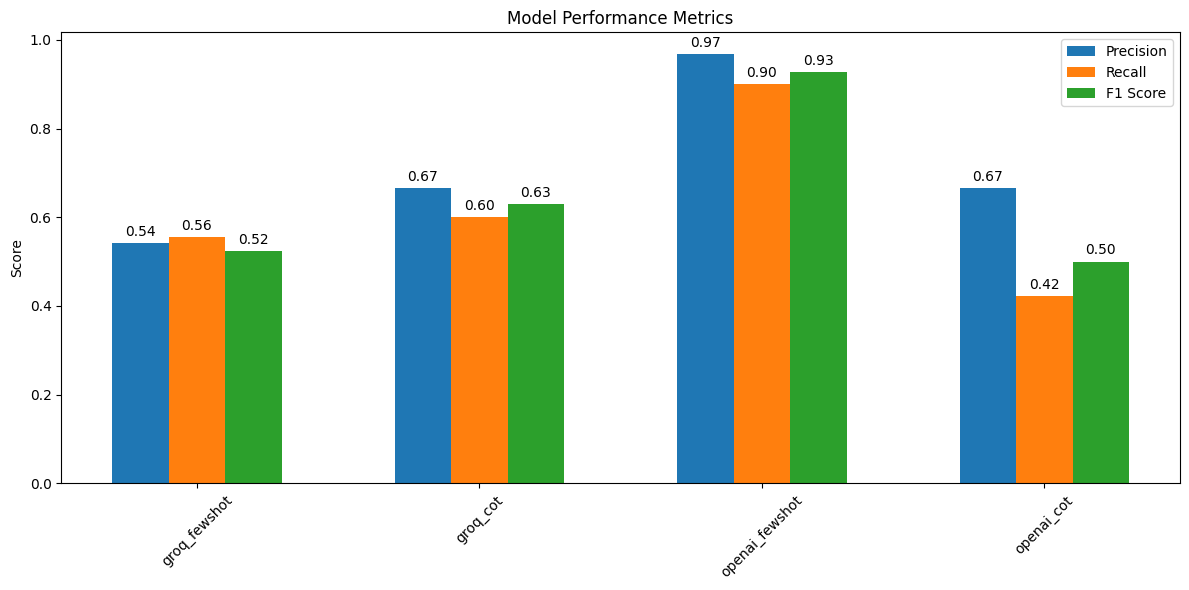

In [23]:
# Small 20 Sample Result
metrics = {}
for model in ["groq", "openai"]:
    for style in ["fewshot", "cot"]:
        pred_col = f"{model}_pred_{style}"
        if pred_col in results.columns:
            precision, recall, f1 = evaluate_predictions(results, label_col, pred_col)
            metrics[f"{model}_{style}"] = {'precision': precision, 'recall': recall, 'f1': f1}

plot_metrics(metrics)

In [ ]:
def clean_predictions_column(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert strings like '1' to numbers
    df[column] = df[column].dropna().astype(int)  # Drop NaNs from bad rows and convert float -> int
    return df

In [ ]:
df_to_use = clean_predictions_column(df_to_use, "groq_pred_fewshot")
df_to_use = clean_predictions_column(df_to_use, "groq_pred_cot")
df_to_use = clean_predictions_column(df_to_use, "openai_pred_cot")
df_to_use = clean_predictions_column(df_to_use, "openai_pred_fewshot")

In [12]:
# Temporary Evaluation + Plot for Incomplete Data
def evaluate_predictions(results):
    metrics = {}
    label_col = "label"

    for model in ["groq", "openai"]:
        for style in ["fewshot", "cot"]:
            pred_col = f"{model}_pred_{style}"
            if pred_col in results.columns:
                try:
                    y_true = pd.to_numeric(results[label_col], errors='coerce')
                    y_pred = pd.to_numeric(results[pred_col], errors='coerce')
                    mask = y_true.notnull() & y_pred.notnull()
                    sample_size = mask.sum()
                    precision, recall, f1, _ = precision_recall_fscore_support(
                        y_true[mask], y_pred[mask], average='macro', zero_division=0
                    )
                    metrics[f"{model}_{style}"] = {
                        'precision': precision,
                        'recall': recall,
                        'f1': f1,
                        'samples': sample_size
                    }
                    print(f"\nEvaluation for {pred_col} ({sample_size} samples):")
                    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
                    print(classification_report(y_true[mask], y_pred[mask], zero_division=0))
                except Exception as e:
                    print(f"Could not evaluate {pred_col}: {e}")
    return metrics

def plot_metrics(metrics):
    models = list(metrics.keys())
    precision = [metrics[m]['precision'] for m in models]
    recall = [metrics[m]['recall'] for m in models]
    f1 = [metrics[m]['f1'] for m in models]
    samples = [metrics[m]['samples'] for m in models]

    x = range(len(models))
    plt.figure(figsize=(12,6))
    bars1 = plt.bar(x, precision, width=0.2, label='Precision')
    bars2 = plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall')
    bars3 = plt.bar([i + 0.4 for i in x], f1, width=0.2, label='F1 Score')

    plt.xticks([i + 0.2 for i in x], models, rotation=45)
    plt.ylabel('Score')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.tight_layout()

    for i, bar_group in enumerate([bars1, bars2, bars3]):
        for j, bar in enumerate(bar_group):
            height = bar.get_height()
            plt.annotate(f'{height:.2f}\n(n={samples[j]})',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom')

    plt.show()


Evaluation for groq_pred_fewshot (12501 samples):
Precision: 0.625, Recall: 0.618, F1: 0.552
              precision    recall  f1-score   support

          -1       0.97      0.62      0.76      6941
           0       0.01      0.37      0.02        76
           1       0.89      0.87      0.88      5484

    accuracy                           0.73     12501
   macro avg       0.62      0.62      0.55     12501
weighted avg       0.93      0.73      0.81     12501


Evaluation for openai_pred_fewshot (30466 samples):
Precision: 0.607, Recall: 0.595, F1: 0.584
              precision    recall  f1-score   support

          -1       0.84      0.96      0.90     16614
           0       0.02      0.12      0.04       320
           1       0.95      0.71      0.82     13532

    accuracy                           0.84     30466
   macro avg       0.61      0.59      0.58     30466
weighted avg       0.88      0.84      0.85     30466


Evaluation for openai_pred_cot (18751 samples):

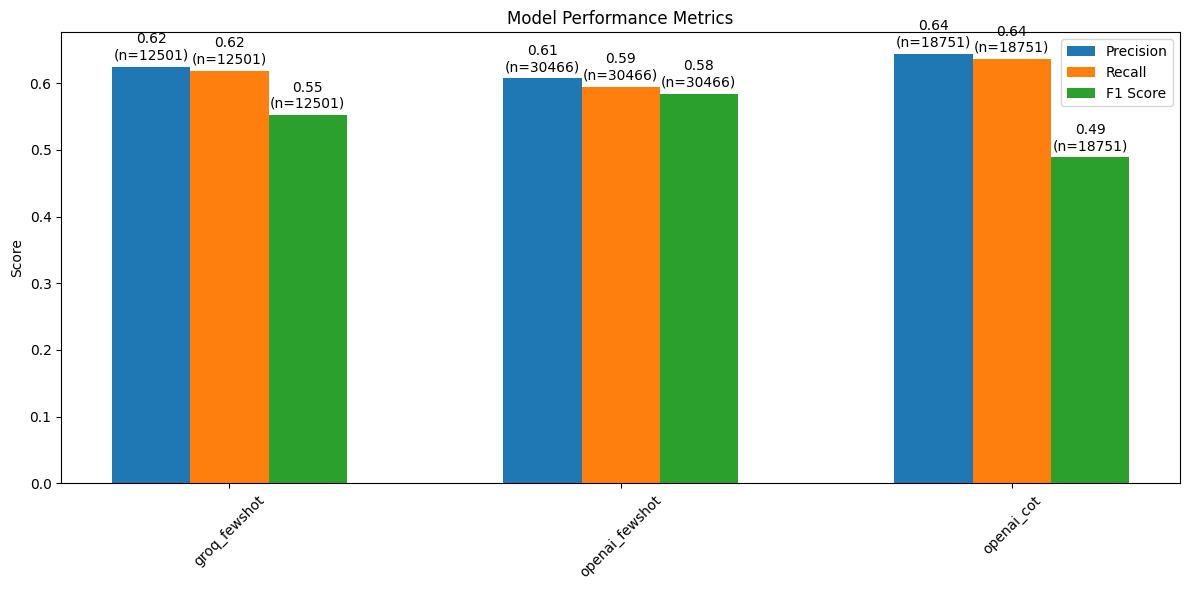

In [13]:
results_df = pd.read_csv(OUTPUT_FILE)
metrics = evaluate_predictions(results_df)
plot_metrics(metrics)